# Project 3: Web APIs & Classification

## Pre-processing

This section will perform the following:
- combine the r/TalesFromTheCustomer and r/TalesFromRetail data
- drop null values
- create a combined text column based on the title + selftext
- create a target column based on the subreddit
- create 3 columns based on the type of shortening used: Lemmatizing, Stemming or none

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [2]:
# Set global random seed
np.random.seed(42)

In [3]:
# Load necessary data ('subreddit', 'selftext' and 'title')
cust = pd.read_csv('datasets/customer.csv')[['subreddit', 'selftext', 'title']]
ret = pd.read_csv('datasets/retail.csv')[['subreddit', 'selftext', 'title']]

In [4]:
# Combine both datasets
df = pd.concat([cust, ret], ignore_index=True)

In [5]:
# Check top 5 rows
df.head()

,subreddit,selftext,title
0,TalesFromTheCustomer,"Please, for the love of all that is holy, read...",A REMINDER of the one rule that everyone overl...
1,TalesFromTheCustomer,A few weeks ago I went to the large chain phar...,Always check your prescriptions
2,TalesFromTheCustomer,I stopped at a local shoe store last week to f...,She broke the biggest rule...
3,TalesFromTheCustomer,Yesterday I went to get my hair cut. Nothing c...,When they do without checkinf
4,TalesFromTheCustomer,"I was having an awful morning, I'd woke up wit...",This is my private property if I tell you to l...


In [6]:
# Check shape
df.shape

(1247, 3)

In [7]:
# Create target column
df['target'] = df['subreddit'].map(lambda x: 1 if x == 'TalesFromRetail' else 0)

In [8]:
# Check target distribution
df['target'].value_counts(normalize=True)

0    0.743384
1    0.256616
Name: target, dtype: float64

In [9]:
# Create combined column for all text data ('title' + 'selftext')
df['text'] = df['title'] + ' ' + df['selftext']

In [10]:
# Check null values
df.isnull().sum()

subreddit    0
selftext     1
title        0
target       0
text         1
dtype: int64

In [11]:
# Drop null values
df.dropna(inplace=True)

In [12]:
# Pre-process text before modelling:
def process_text(doc, lem_stem=None):
    # Select letters only
    letters_only = re.sub("[^a-zA-Z]", " ", doc)
    # Split string into list of words
    all_words = letters_only.lower().split()
    
    # Include talesfromretail and talesfromthecustomer into list of stop words
    # Cvec and Tvec stop words will be used also subsequently
    stop = stopwords.words('english')
    stop.extend(['talesfromretail', 'talesfromthecustomer'])
    words = [w for w in all_words if w not in stop]
    
    # Lemmatize/stem the list of words accordingly
    if lem_stem == 'lem':
        lem = WordNetLemmatizer()
        words_shortened = [lem.lemmatize(word) for word in words]
        
    elif lem_stem == 'stem':
        stem = PorterStemmer()
        words_shortened = [stem.stem(word) for word in words]
    
    # Allow option without lemmatizing or stemming. Only remove stop words and non-letters
    else:
        words_shortened = words
    
    # Return combined string of lemmatized/stemmed words
    return(" ".join(words_shortened))

In [13]:
# Create new columns for lemmatized/stemmed text
df['text_lem'] = df['text'].map(lambda x: process_text(x,'lem'))
df['text_stem'] = df['text'].map(lambda x: process_text(x,'stem'))

# Create column for processed text without lemmatizing/stemming for EDA and comparison purposes
df['text_raw'] = df['text'].map(lambda x: process_text(x))

In [14]:
# Check top 5 rows again
df.head()

,subreddit,selftext,title,target,text,text_lem,text_stem,text_raw
0,TalesFromTheCustomer,"Please, for the love of all that is holy, read...",A REMINDER of the one rule that everyone overl...,0,A REMINDER of the one rule that everyone overl...,reminder one rule everyone overlook please lov...,remind one rule everyon overlook pleas love ho...,reminder one rule everyone overlooks please lo...
1,TalesFromTheCustomer,A few weeks ago I went to the large chain phar...,Always check your prescriptions,0,Always check your prescriptions A few weeks ag...,always check prescription week ago went large ...,alway check prescript week ago went larg chain...,always check prescriptions weeks ago went larg...
2,TalesFromTheCustomer,I stopped at a local shoe store last week to f...,She broke the biggest rule...,0,She broke the biggest rule... I stopped at a l...,broke biggest rule stopped local shoe store la...,broke biggest rule stop local shoe store last ...,broke biggest rule stopped local shoe store la...
3,TalesFromTheCustomer,Yesterday I went to get my hair cut. Nothing c...,When they do without checkinf,0,When they do without checkinf Yesterday I went...,without checkinf yesterday went get hair cut n...,without checkinf yesterday went get hair cut n...,without checkinf yesterday went get hair cut n...
4,TalesFromTheCustomer,"I was having an awful morning, I'd woke up wit...",This is my private property if I tell you to l...,0,This is my private property if I tell you to l...,private property tell leave aka doorknocker sk...,privat properti tell leav aka doorknock skill ...,private property tell leave aka doorknockers s...


## EDA

This section will examine the most frequent words in each subreddit, as well as the top unique words to each subreddit.

In [15]:
# Combine all text data by subreddit
customer_text = ''
for text in df.loc[df['target'] == 0]['text_raw']:
    customer_text += text + ' '
    
retail_text = ''
for text in df.loc[df['target'] == 1]['text_raw']:
    retail_text += text + ' '

In [16]:
# Create wordclouds for each subreddit
wordcloud_cust = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black',
                           colormap='Set2', collocations=False).generate(customer_text)
wordcloud_ret = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black',
                           colormap='Set2', collocations=False).generate(retail_text)

In [17]:
# Create plotting function
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

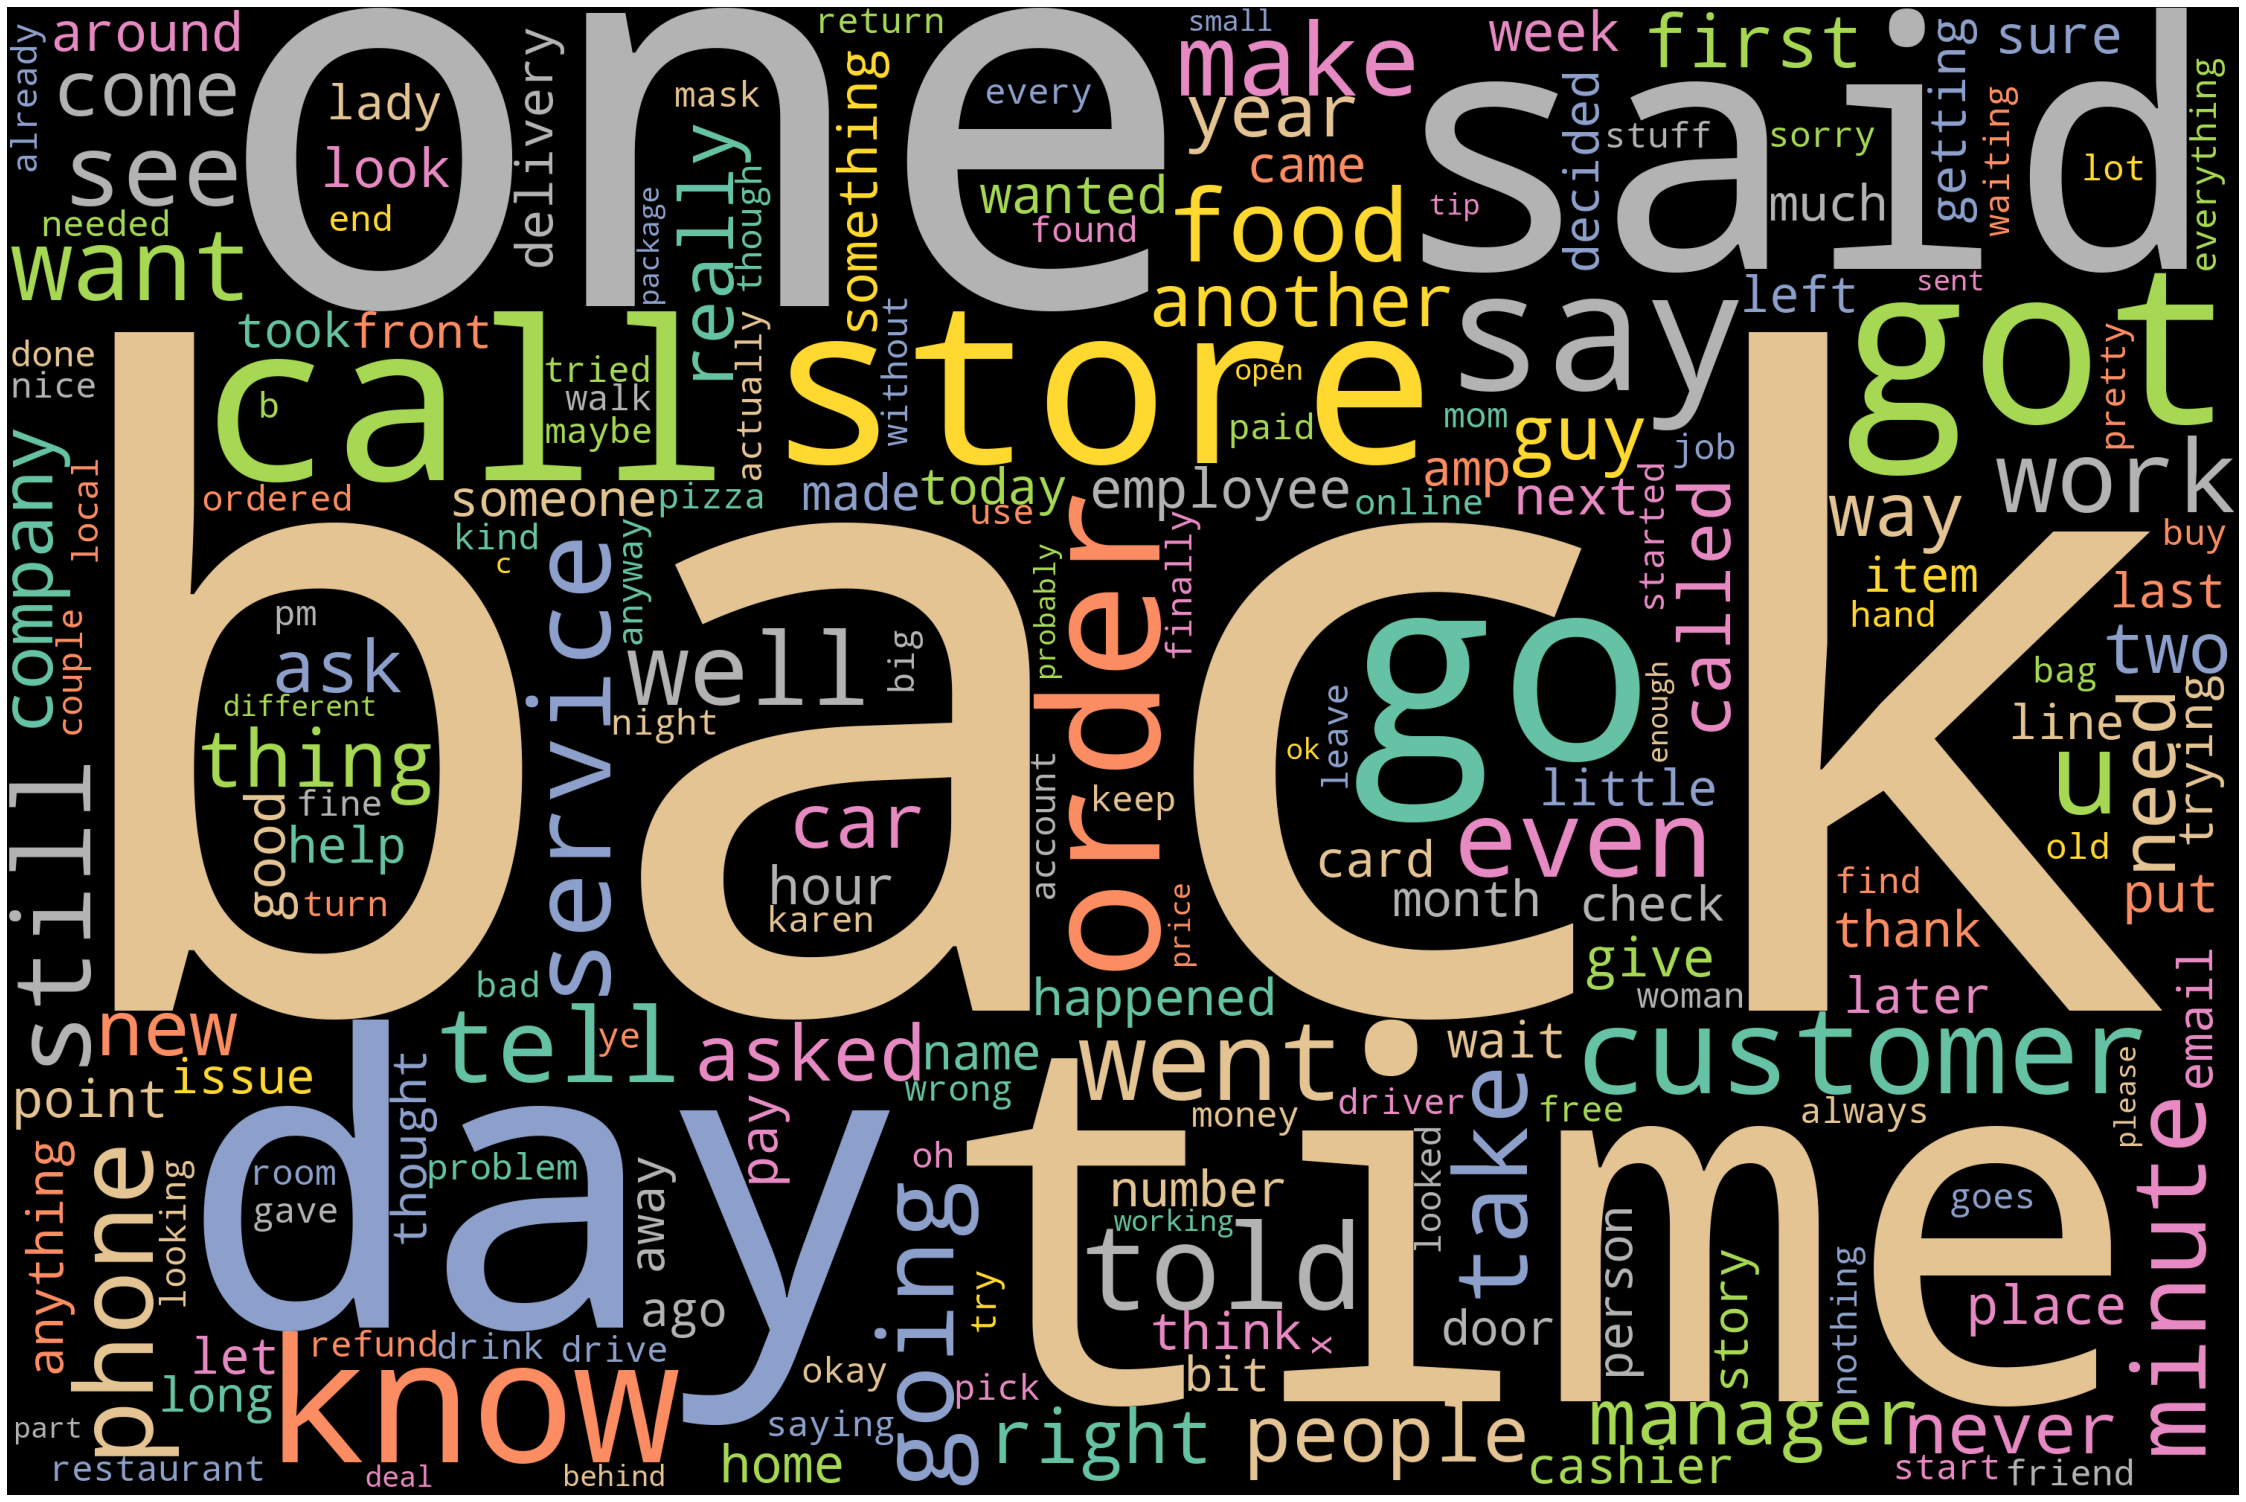

In [18]:
# Examine TalesFromTheCustomer wordcloud
plot_cloud(wordcloud_cust) 

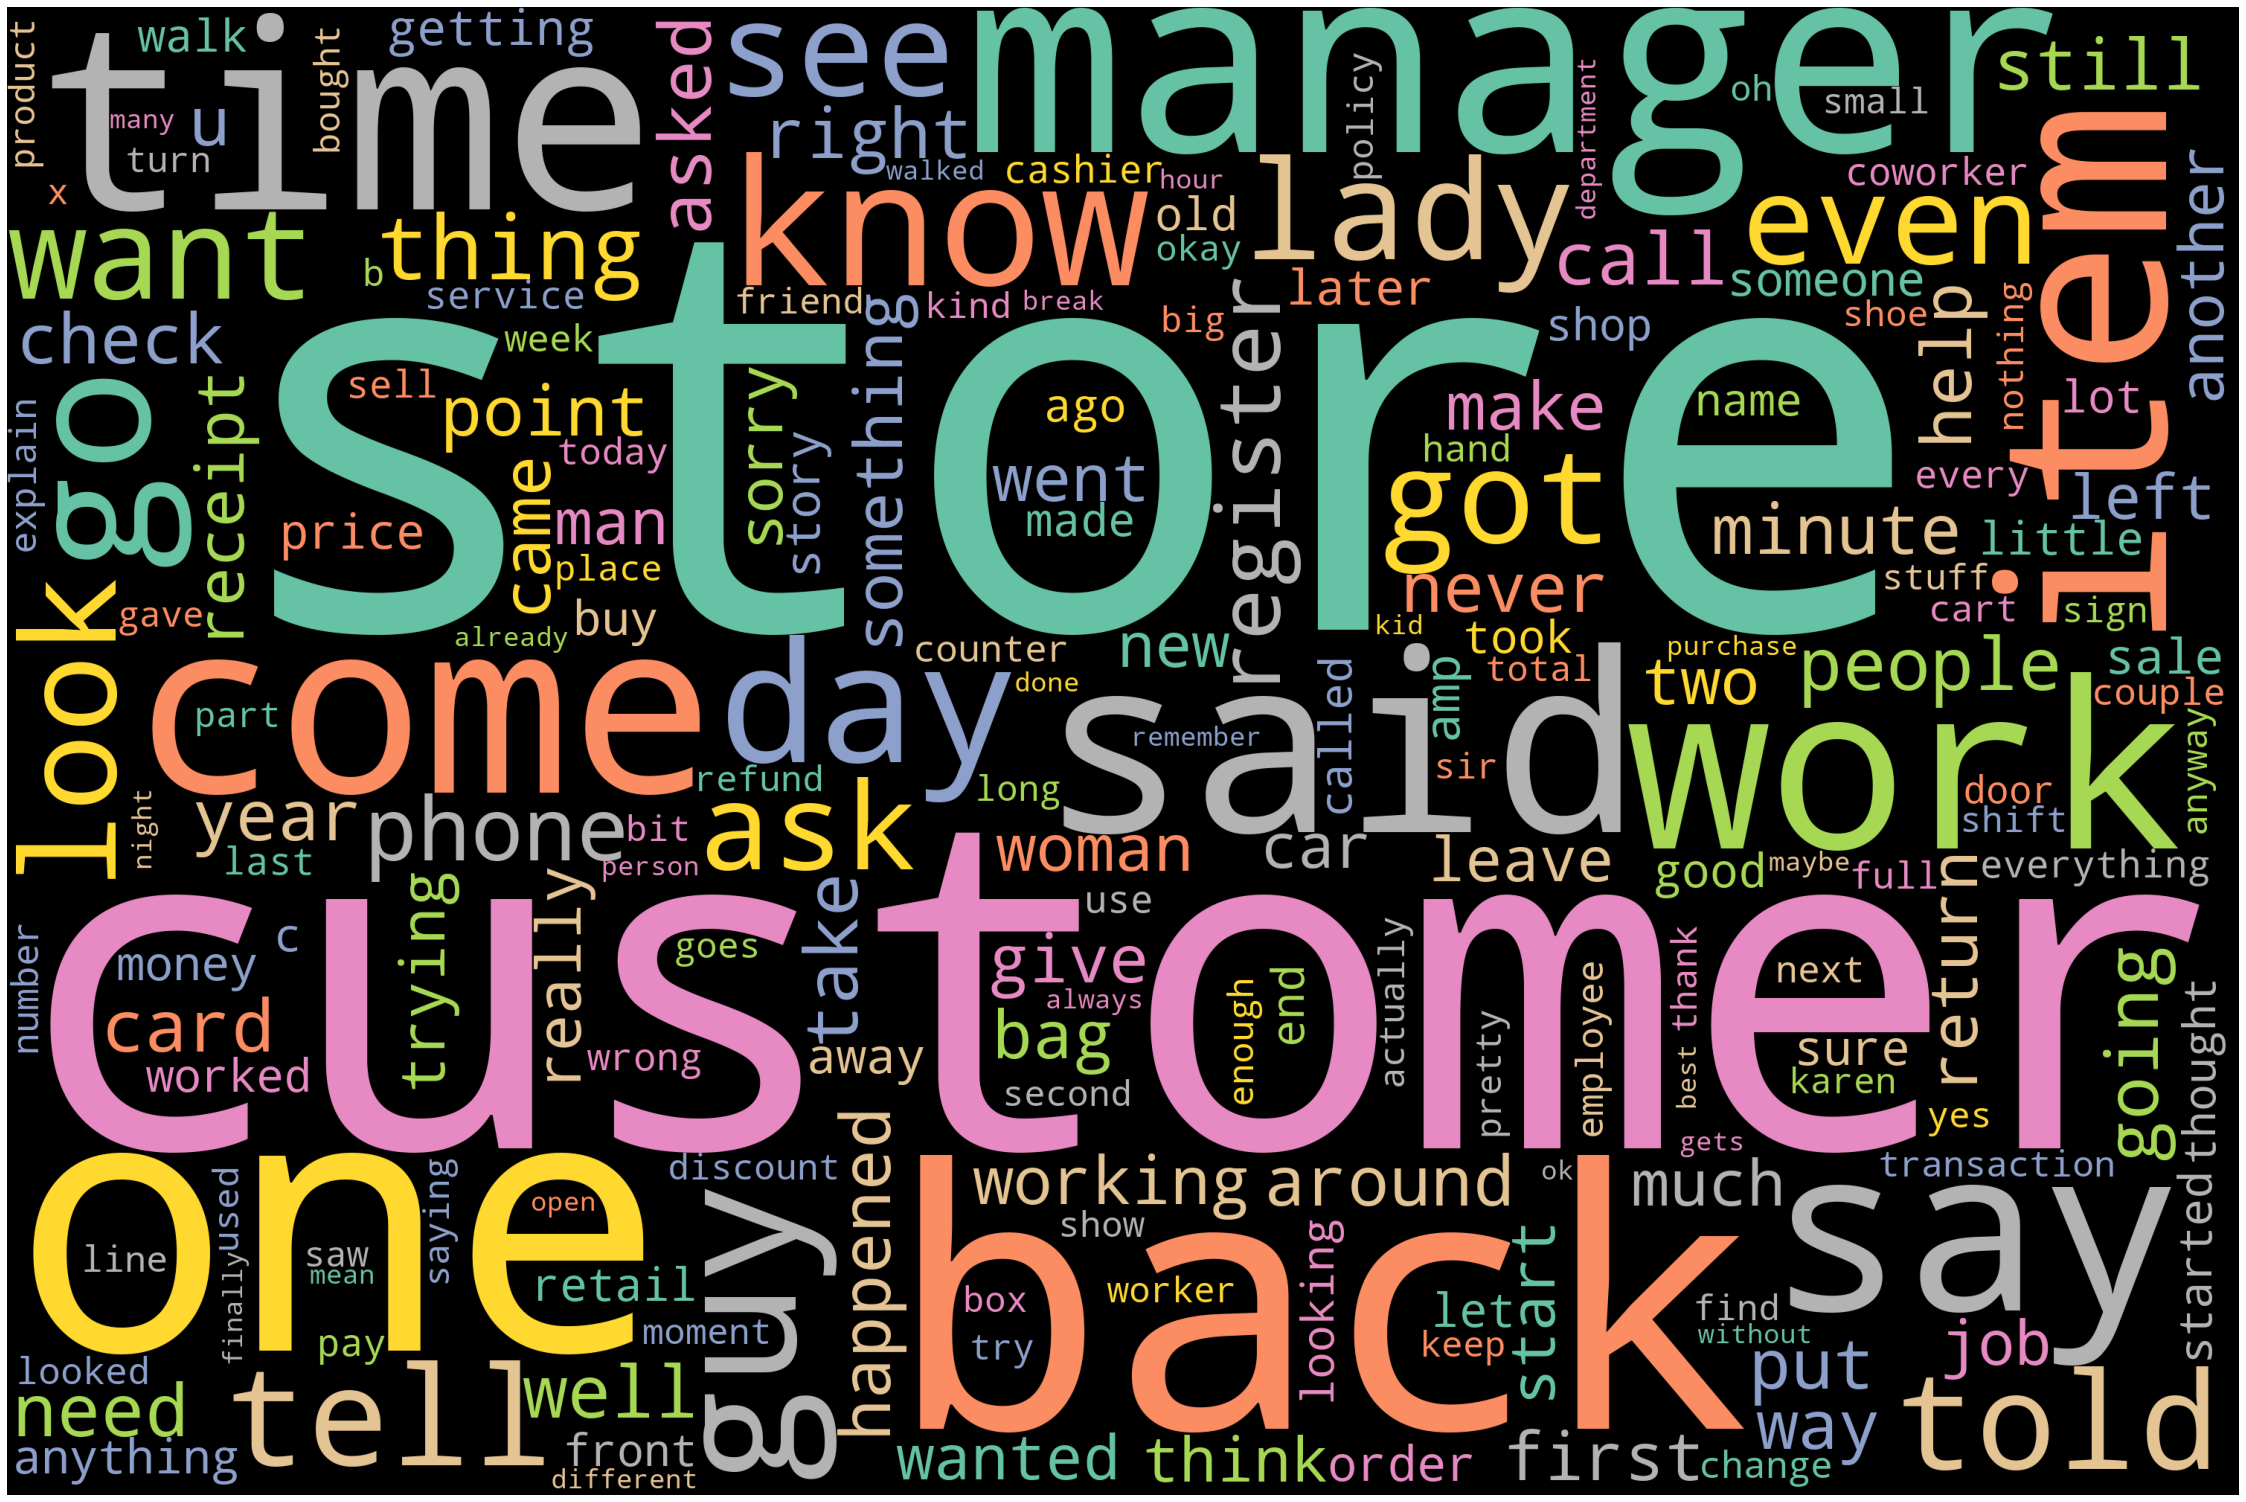

In [19]:
# Examine TalesFromRetail wordcloud
plot_cloud(wordcloud_ret) 

In [20]:
# Create word counter using CountVectorizer
def top_n_words(text, n):
    # Initialize and fit CountVectorizer onto text
    cv = CountVectorizer()
    cv_fit = cv.fit_transform([text])
    
    # Obtain word list and counts
    word_list = cv.get_feature_names()
    count_list = np.asarray(cv_fit.sum(axis=0))[0]
    
    # Create df to display word, count and frequency
    text_df = pd.DataFrame(index=[i for i in range(len(word_list))])
    text_df['word'] = word_list
    text_df['count'] = count_list
    text_df['frequency'] = text_df['count'] / text_df['count'].sum()
    
    # Return top n most frequent words
    return text_df.sort_values(by='count', ascending=False).head(n)

In [21]:
# Examine top 20 words in r/TalesFromTheCustomer
top_n_words(customer_text, 20)

,word,count,frequency
4832,get,1807,0.009852
799,back,1457,0.007944
7804,one,1323,0.007213
13052,would,1119,0.006101
11816,time,1047,0.005708
6565,like,1040,0.005670
9904,said,1031,0.005621
4919,go,979,0.005338
4961,got,957,0.005218
11128,store,891,0.004858


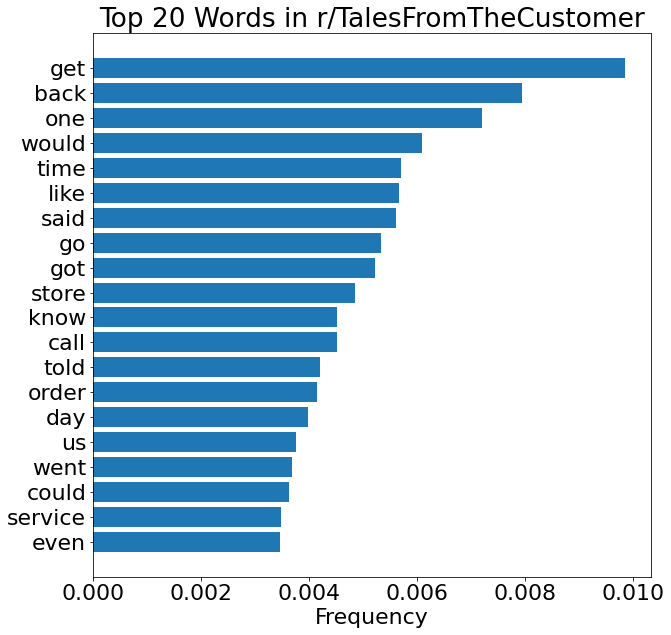

In [22]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.barh(top_n_words(customer_text, 20)['word'], top_n_words(customer_text, 20)['frequency'])
plt.title('Top 20 Words in r/TalesFromTheCustomer')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

In [23]:
# Examine top 20 words in r/TalesFromRetail
top_n_words(retail_text, 20)

,word,count,frequency
6276,store,673,0.011043
449,back,537,0.008812
4423,one,525,0.008615
1592,customer,501,0.008221
2765,get,446,0.007318
3740,like,394,0.006465
3931,manager,351,0.005760
5543,said,342,0.005612
6698,time,323,0.005300
7366,would,321,0.005267


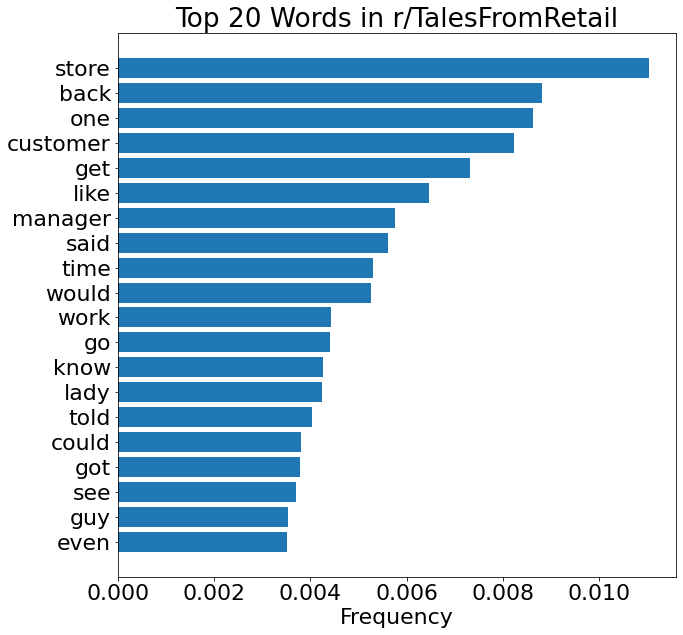

In [24]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.barh(top_n_words(retail_text, 20)['word'], top_n_words(retail_text, 20)['frequency'])
plt.title('Top 20 Words in r/TalesFromRetail')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

From the word clouds and bar charts, it is clear that many words are frequent to both subreddits, such as 'back', 'store', 'get', 'time' and 'one'. This is to be expected given the similar topics and narrative structure in both subreddits. 

Given their high frequency in both datasets, these words may not be useful for the classification models to distinguish between the 2 subreddits. For example in a Multinomial Naive Bayes model, similar frequencies of a word in both subreddits will result in similar probabilities for that word (i.e. P(word|r/TalesFromTheCustomer) will be similar to P(word|r/TalesFromRetail)). This decreases the distinguishing ability of the word to the model.

We can delve deeper by examining the top most frequent unique words to each subreddit.

In [25]:
# Create function to generate top n words unique to each dataset
def text_1_n_unique_words(text_1, text_2, n):
    
    # Initialize and fit CountVectorizer onto texts
    cv_1 = CountVectorizer()
    cv_fit_1 = cv_1.fit_transform([text_1])
    
    cv_2 = CountVectorizer()
    cv_fit_2 = cv_2.fit_transform([text_2])    
    
    # Obtain word list and counts
    word_list_1 = cv_1.get_feature_names()
    count_list_1 = np.asarray(cv_fit_1.sum(axis=0))[0]
    
    word_list_2 = cv_2.get_feature_names()
    
    # Create df to display word, count and frequency
    df_1 = pd.DataFrame(index=[i for i in range(len(word_list_1))])
    df_1['word'] = word_list_1
    df_1['count'] = count_list_1
    df_1['frequency'] = df_1['count'] / df_1['count'].sum()
    
    # Drop words in text_1 which are in text_2
    df_1 = df_1.drop(df_1[df_1['word'].isin(word_list_2)].index)
    
    # Return top n most frequent unique words in text_1
    return df_1.sort_values(by='count', ascending=False).head(n)

In [26]:
text_1_n_unique_words(customer_text, retail_text, 20)

,word,count,frequency
8395,pizza,250,0.001363
9602,restaurant,204,0.001112
10230,server,136,0.000742
6969,meal,77,0.000420
3418,doctor,74,0.000403
224,agent,59,0.000322
3084,dentist,57,0.000311
441,apartment,56,0.000305
6391,laptop,55,0.000300
10183,seller,53,0.000289


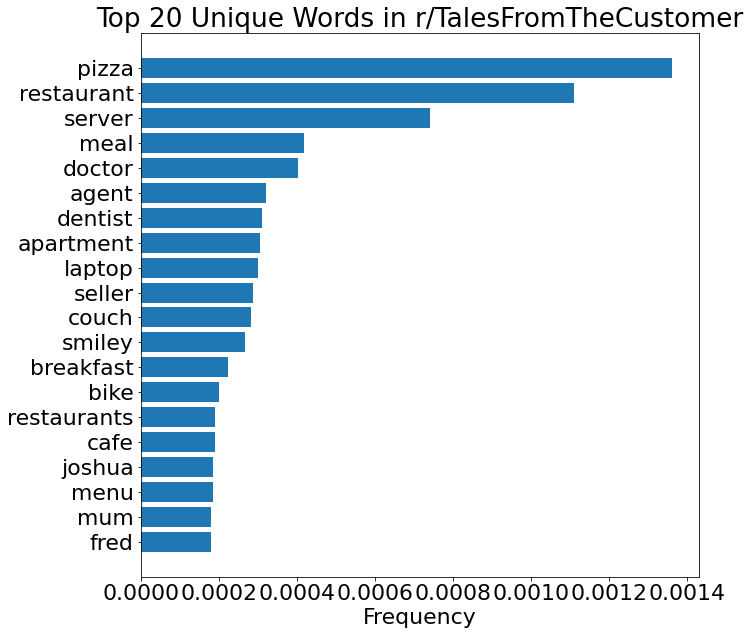

In [27]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.barh(text_1_n_unique_words(customer_text, retail_text, 20)['word'], text_1_n_unique_words(customer_text, retail_text, 20)['frequency'])
plt.title('Top 20 Unique Words in r/TalesFromTheCustomer')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

In [28]:
df.loc[df['text_raw'].str.contains('pizza')]

,subreddit,selftext,title,target,text,text_lem,text_stem,text_raw
18,TalesFromTheCustomer,I ordered pizza from a small town shop last ni...,Pizza Shop That Will Not Give Change On Delivery,0,Pizza Shop That Will Not Give Change On Delive...,pizza shop give change delivery ordered pizza ...,pizza shop give chang deliveri order pizza sma...,pizza shop give change delivery ordered pizza ...
26,TalesFromTheCustomer,"About 8/9 years ago, my then bf and I liked to...",I miss brightening their evening,0,I miss brightening their evening About 8/9 yea...,miss brightening evening year ago bf liked ord...,miss brighten even year ago bf like order pizz...,miss brightening evening years ago bf liked or...
51,TalesFromTheCustomer,"So I live in a northern country, and we have a...",The first time I’ve ever given a negative revi...,0,The first time I’ve ever given a negative revi...,first time ever given negative review delivery...,first time ever given neg review deliveri driv...,first time ever given negative review delivery...
84,TalesFromTheCustomer,"Before corona, I used to always get pizza for ...",My Prawn pizza wasn’t cooked but I couldn’t Co...,0,My Prawn pizza wasn’t cooked but I couldn’t Co...,prawn pizza cooked complain delivery guy alway...,prawn pizza cook complain deliveri guy alway r...,prawn pizza cooked complain delivery guy alway...
127,TalesFromTheCustomer,Last Friday night I stayed at a Haul-a-Way Inn...,Hotel front desk attendant checks me into wron...,0,Hotel front desk attendant checks me into wron...,hotel front desk attendant check wrong room un...,hotel front desk attend check wrong room unawa...,hotel front desk attendant checks wrong room u...
147,TalesFromTheCustomer,Just got pizza delivered and when I opened the...,The missing piece of pizza,0,The missing piece of pizza Just got pizza deli...,missing piece pizza got pizza delivered opened...,miss piec pizza got pizza deliv open box one p...,missing piece pizza got pizza delivered opened...
183,TalesFromTheCustomer,I just learned of this subs existence so here’...,Pizza chain worker being awful to an elderly w...,0,Pizza chain worker being awful to an elderly w...,pizza chain worker awful elderly woman learned...,pizza chain worker aw elderli woman learn sub ...,pizza chain worker awful elderly woman learned...
191,TalesFromTheCustomer,Before I start a few abbreviations for names.\...,Waited an hour for a wrong order,0,Waited an hour for a wrong order Before I star...,waited hour wrong order start abbreviation nam...,wait hour wrong order start abbrevi name ppe p...,waited hour wrong order start abbreviations na...
197,TalesFromTheCustomer,By far the worst customer service experience I...,Unbelievable Blominos experience,0,Unbelievable Blominos experience By far the wo...,unbelievable blominos experience far worst cus...,unbeliev blomino experi far worst custom servi...,unbelievable blominos experience far worst cus...
211,TalesFromTheCustomer,Tldr: at the end.This happened two nights ago ...,I just experienced the craziest thing at a gro...,0,I just experienced the craziest thing at a gro...,experienced craziest thing grocery store appar...,experienc craziest thing groceri store appar a...,experienced craziest thing grocery store appar...


For r/TalesFromTheCustomer, the most frequent unique words are 'pizza', 'restaurant' and 'server'. This is unsurprising as there may be several bad experiences from customers regarding pizza restaurants. Other unique words include descriptions of service providers such as 'doctor', 'dentist', 'agent' and 'seller'.

Given that 'pizza', 'restaurant' and 'server' are unique to r/TalesFromTheCustomer and have relatively high frequencies, they could be useful for the model to identify if a post is from r/TalesFromTheCustomer.

In [29]:
text_1_n_unique_words(retail_text, customer_text, 20)

,word,count,frequency
1601,cw,31,0.000509
7400,yarn,24,0.000394
3610,ladder,15,0.000246
2191,epd,14,0.000230
2494,fireworks,13,0.000213
650,blade,13,0.000213
920,candles,13,0.000213
6886,tw,13,0.000213
3050,heelys,12,0.000197
775,brian,11,0.000180


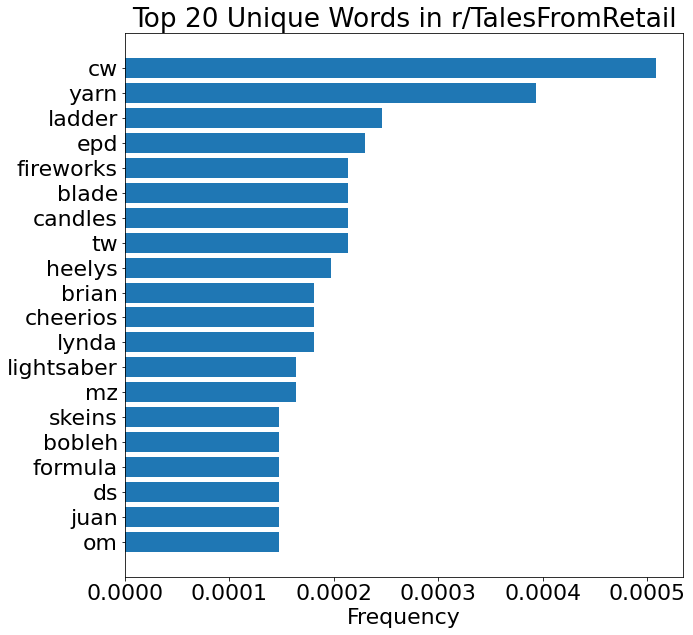

In [30]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(10,10))
plt.barh(text_1_n_unique_words(retail_text, customer_text, 20)['word'], text_1_n_unique_words(retail_text, customer_text, 20)['frequency'])
plt.title('Top 20 Unique Words in r/TalesFromRetail')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()

In [31]:
df.loc[df['text_raw'].str.contains('cw')]

,subreddit,selftext,title,target,text,text_lem,text_stem,text_raw
989,TalesFromRetail,"So this happened a week ago or so, and it’s st...","For the Last Time Sir, We Don’t Have Diesel",1,"For the Last Time Sir, We Don’t Have Diesel So...",last time sir diesel happened week ago still m...,last time sir diesel happen week ago still min...,last time sir diesel happened week ago still m...
1018,TalesFromRetail,I've worked in retain for almost five years no...,Give me my f**king lottery ticket,1,Give me my f**king lottery ticket I've worked ...,give f king lottery ticket worked retain almos...,give f king lotteri ticket work retain almost ...,give f king lottery ticket worked retain almos...
1111,TalesFromRetail,EDIT: Thank you for the silver!\n\n&amp;#x200B...,Guy gets angry at me for being meticulous,1,Guy gets angry at me for being meticulous EDIT...,guy get angry meticulous edit thank silver amp...,guy get angri meticul edit thank silver amp x ...,guy gets angry meticulous edit thank silver am...
1178,TalesFromRetail,"So this happened in 2019, I think later 2019 I...","We ""wasted"" 20 minutes of this lady's time bec...",1,"We ""wasted"" 20 minutes of this lady's time bec...",wasted minute lady time check machine working ...,wast minut ladi time check machin work happen ...,wasted minutes lady time check machine working...
1198,TalesFromRetail,So heads up I'm on Mobile so sorry for any mis...,Customer threatens to sue me because he decide...,1,Customer threatens to sue me because he decide...,customer threatens sue decided jump turnstile ...,custom threaten sue decid jump turnstil head m...,customer threatens sue decided jump turnstile ...


In [32]:
df.loc[df['text_raw'].str.contains('epd')]

,subreddit,selftext,title,target,text,text_lem,text_stem,text_raw
1179,TalesFromRetail,\n\nFirst-time poster.\n\nBack story: This is...,Entitled Gas Customer,1,Entitled Gas Customer \n\nFirst-time poster.\...,entitled gas customer first time poster back s...,entitl ga custom first time poster back stori ...,entitled gas customer first time poster back s...


For r/TalesFromRetail, some of the top unique words include items unique to specific posts such as 'yarn', 'ladder' or 'fireworks'. They also include abbreviations used to describe people in the posts such as 'cw': co-worker, 'epd': entitled pennsylvania driver and  'tw': the wife.

Other than 'cw', these unique words are generally found within only 1 or 2 posts and have very low frequencies within the entire subreddit corpus.

Thus, only 'cw' could be useful to the NLP classification models as it is unlikely for new posts to contain the other words.

## Modelling

This section will first iterate through various shorteners, vectorizers and models before selecting a subset of models to grid search on.

### Screening

In [33]:
# Create results placeholder
results = []

# Create lists of shorteners, vectorizers and models to trial
shorteners  = ['stem', 'lem', 'raw']
vectorizers = ['cvec', 'tvec']
models      = ['log_reg', 'knn', 'nb', 'rf', 'et', 'svm']

# Iterate through shorteners, vectorizers and models
for shortener in shorteners:
    for vectorizer in vectorizers:
        for model in models:
            
            # Create train and test sets based on shortener
            X = df[f'text_{shortener}']
            y = df['target']
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
            
            # Create vectorizer
            if vectorizer == 'cvec':
                vec = CountVectorizer(stop_words='english')
            elif vectorizer == 'tvec':
                vec = TfidfVectorizer(stop_words='english')
            
            # Fit and transform vectorizer
            X_train = vec.fit_transform(X_train)
            X_test  = vec.transform(X_test)
            
            # Create model
            if model == 'log_reg':
                classifier = LogisticRegression()
            elif model == 'knn':
                classifier = KNeighborsClassifier()
            elif model == 'nb':
                classifier = MultinomialNB()
            elif model == 'rf':
                classifier = RandomForestClassifier()
            elif model == 'et':
                classifier = ExtraTreesClassifier()
            elif model == 'svm':
                classifier = SVC()

            
            # Fit and score model
            classifier.fit(X_train, y_train)
            
            cv_accuracy   = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'accuracy').mean()
            cv_f1         = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'f1').mean()
            cv_roc        = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'roc_auc').mean()
            cv_precision  = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'precision').mean()
            cv_recall     = cross_val_score(classifier, X_train, y_train, cv=5, scoring = 'recall').mean()
            
            test_accuracy = classifier.score(X_test, y_test)
            test_f1       = f1_score(y_test, classifier.predict(X_test))
            test_roc      = roc_auc_score(y_test, classifier.predict(X_test))
            test_precision= precision_score(y_test, classifier.predict(X_test))
            test_recall   = recall_score(y_test, classifier.predict(X_test))
            
            # Append to results
            results.append({'shortener'     : shortener,
                            'vectorizer'    : vectorizer,
                            'model'         : model,
                            'cv accuracy'   : cv_accuracy,
                            'cv f1 score'   : cv_f1,
                            'cv roc auc'    : cv_roc,
                            'cv precision'  : cv_precision,
                            'cv recall'     : cv_recall,
                            'test accuracy' : test_accuracy,
                            'test f1 score' : test_f1,
                            'test roc auc'  : test_roc,
                            'test precision': test_precision,
                            'test recall'   : test_recall})           

C:\Users\weezi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weezi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weezi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\weezi\anaconda3\envs\dsi\lib\site-packages\sklearn\metrics\_classification.py:1221

In [34]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df

,shortener,vectorizer,model,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
0,stem,cvec,log_reg,0.868076,0.716451,0.926153,0.792473,0.667663,0.868932,0.712766,0.791528,0.817073,0.632075
1,stem,cvec,knn,0.760219,0.266824,0.673416,0.617143,0.173200,0.771845,0.347222,0.596683,0.657895,0.235849
2,stem,cvec,nb,0.835712,0.685965,0.889784,0.671954,0.704983,0.830097,0.692982,0.802380,0.647541,0.745283
3,stem,cvec,rf,0.763783,0.160928,0.868965,0.883333,0.102990,0.788835,0.325581,0.595789,0.913043,0.198113
4,stem,cvec,et,0.766193,0.167250,0.820476,1.000000,0.084275,0.771845,0.203390,0.556604,1.000000,0.113208
5,stem,cvec,svm,0.824940,0.519115,0.920934,0.879326,0.373643,0.832524,0.554839,0.693026,0.877551,0.405660
6,stem,tvec,log_reg,0.766178,0.165756,0.927652,0.966667,0.093245,0.800971,0.388060,0.619374,0.928571,0.245283
7,stem,tvec,knn,0.773364,0.477517,0.804222,0.581337,0.406202,0.781553,0.536082,0.686459,0.590909,0.490566
8,stem,tvec,nb,0.743410,0.000000,0.771426,0.000000,0.000000,0.742718,0.000000,0.500000,0.000000,0.000000
9,stem,tvec,rf,0.767383,0.160929,0.874240,1.000000,0.107309,0.783981,0.299213,0.586355,0.904762,0.179245


In [35]:
# Display top 10 performing models by test accuracy
results_df.sort_values('test accuracy', ascending=False).head(10)

,shortener,vectorizer,model,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
0,stem,cvec,log_reg,0.868076,0.716451,0.926153,0.792473,0.667663,0.868932,0.712766,0.791528,0.817073,0.632075
24,raw,cvec,log_reg,0.859664,0.686896,0.928853,0.787263,0.616168,0.859223,0.691489,0.778826,0.792683,0.613208
12,lem,cvec,log_reg,0.865645,0.706400,0.925425,0.787567,0.653378,0.851942,0.673797,0.767758,0.777778,0.594340
26,raw,cvec,nb,0.847753,0.703241,0.894201,0.712354,0.700664,0.839806,0.679612,0.781169,0.700000,0.660377
17,lem,cvec,svm,0.814148,0.480700,0.917439,0.848663,0.340864,0.837379,0.562092,0.696294,0.914894,0.405660
14,lem,cvec,nb,0.836931,0.684520,0.885759,0.680354,0.691251,0.837379,0.691244,0.794950,0.675676,0.707547
5,stem,cvec,svm,0.824940,0.519115,0.920934,0.879326,0.373643,0.832524,0.554839,0.693026,0.877551,0.405660
2,stem,cvec,nb,0.835712,0.685965,0.889784,0.671954,0.704983,0.830097,0.692982,0.802380,0.647541,0.745283
29,raw,cvec,svm,0.809350,0.438540,0.920105,0.901754,0.294241,0.820388,0.493151,0.663275,0.900000,0.339623
23,lem,tvec,svm,0.770969,0.190311,0.925487,1.000000,0.107198,0.817961,0.468085,0.652392,0.942857,0.311321


In [36]:
# Check baseline accuracy score based on majority class
df['target'].value_counts(normalize=True)

0    0.743178
1    0.256822
Name: target, dtype: float64

In [37]:
# Display top 10 performing models by test f1 score
results_df.sort_values('test f1 score', ascending=False).head(10)

,shortener,vectorizer,model,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
0,stem,cvec,log_reg,0.868076,0.716451,0.926153,0.792473,0.667663,0.868932,0.712766,0.791528,0.817073,0.632075
2,stem,cvec,nb,0.835712,0.685965,0.889784,0.671954,0.704983,0.830097,0.692982,0.802380,0.647541,0.745283
24,raw,cvec,log_reg,0.859664,0.686896,0.928853,0.787263,0.616168,0.859223,0.691489,0.778826,0.792683,0.613208
14,lem,cvec,nb,0.836931,0.684520,0.885759,0.680354,0.691251,0.837379,0.691244,0.794950,0.675676,0.707547
26,raw,cvec,nb,0.847753,0.703241,0.894201,0.712354,0.700664,0.839806,0.679612,0.781169,0.700000,0.660377
12,lem,cvec,log_reg,0.865645,0.706400,0.925425,0.787567,0.653378,0.851942,0.673797,0.767758,0.777778,0.594340
17,lem,cvec,svm,0.814148,0.480700,0.917439,0.848663,0.340864,0.837379,0.562092,0.696294,0.914894,0.405660
19,lem,tvec,knn,0.773350,0.450794,0.797395,0.588519,0.368549,0.798544,0.560847,0.700980,0.638554,0.500000
5,stem,cvec,svm,0.824940,0.519115,0.920934,0.879326,0.373643,0.832524,0.554839,0.693026,0.877551,0.405660
7,stem,tvec,knn,0.773364,0.477517,0.804222,0.581337,0.406202,0.781553,0.536082,0.686459,0.590909,0.490566


In terms of test accuracy, the top 10 models all scored above 0.8. However, given that the dataset has unbalanced classes, classifying the test data based on the majority (r/TalesFromTheCustomer) would have given an accuracy of 0.74 by default. Thus, the high accuracy of the models may be due to the identification of the majority class, and may not represent the predictive ability of the models.

F1 score may be a better metric in this case, as it represents the harmonic mean between precision and recall. Precision and recall are measures of the true positives, and thus measure how well the model identifies the minority target class (r/TalesFromRetail).

We can group the models by shortener, vectorizer and model to examine the differences between them.

In [38]:
# Examine models by shortener
results_df.groupby('shortener').mean()

,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
shortener,,,,,,,,,,
lem,0.780666,0.273866,0.850100,0.774222,0.226800,0.796723,0.381998,0.631415,0.783511,0.290881
raw,0.782573,0.289146,0.854743,0.780564,0.221438,0.794701,0.373360,0.625686,0.770815,0.277516
stem,0.783071,0.304372,0.856249,0.770418,0.243245,0.796926,0.394647,0.636433,0.773210,0.305818


**Shortening:**
Interestingly, the scores are very similar between the raw, lemmatized and stemmed texts. This could be because the texts do not contain high amounts of complex words, such that the effects of lemmatizing or stemming are minimal. 

Lemmatized and stemmed texts performed marginally better in test accuracy, test f1 score and test ROC AUC. For simplicity, we can proceed with lemmatized text for the next section.

In [39]:
# Examine models by vectorizer
results_df.groupby('vectorizer').mean()

,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
vectorizer,,,,,,,,,,
cvec,0.801155,0.399618,0.844503,0.799196,0.333942,0.809196,0.45992,0.665504,0.810746,0.369497
tvec,0.763052,0.178638,0.862891,0.750940,0.127046,0.783037,0.30675,0.596852,0.740945,0.213312


**Vectorizer:**
Count Vectorizer models seem to have performed better than TF-IDF Vectorizer models. This could be because the TF-IDF is a score of the importance of a word to a document relative to other documents. In this case, there may not be a significant difference in word importance between r/TalesFromTheCustomer and r/TalesFromRetail as they are similar subreddits.

In [40]:
# Examine models by model
results_df.groupby('model').mean()

,cv accuracy,cv f1 score,cv roc auc,cv precision,cv recall,test accuracy,test f1 score,test roc auc,test precision,test recall
model,,,,,,,,,,
et,0.761192,0.143890,0.840063,0.917963,0.098080,0.775081,0.236768,0.566490,0.942910,0.136792
knn,0.767985,0.334816,0.726660,0.637806,0.255353,0.778317,0.412882,0.632898,0.637364,0.333333
log_reg,0.813123,0.419405,0.927675,0.882328,0.360170,0.827265,0.521889,0.692569,0.864864,0.415094
nb,0.791771,0.345621,0.834627,0.344110,0.349483,0.789239,0.343973,0.646417,0.337203,0.352201
rf,0.765587,0.157457,0.869492,0.937778,0.098874,0.785599,0.298333,0.586930,0.943318,0.177673
svm,0.792962,0.333580,0.923666,0.930420,0.221004,0.821197,0.486165,0.661765,0.929413,0.333333


**Model:**
Logistic Regression, Support Vector Machine, K-Nearest Neighbours and Multinomial Naive Bayes are the top models in terms of test f1 score.

Logistic Regression, Support Vector Machine and Multinomial Naive Bayes performed best with Count Vectorizer.

K-Nearest Neighbours performed best with TF-IDF Vectorizer.

Extra Trees and Random Forest classifiers had generally poorer f1 scores and ROC AUC. Examining their precision and recall scores, they generally had high precision but very low recall.

The next section will perform grid searching to tune the parameters of the Logistic Regression, Support Vector Machine, K-Nearest Neighbours and Multinomial Naive Bayes models to find the best score.

### Grid Searching

In this section, we will grid search over the Count Vectorizer and model (Logistic Regression, Support Vector Machine and Multinomial Naive Bayes) parameters. We will grid search over TF-IDF Vectorizer and K-Nearest Neighbours parameters.

We will use the lemmatized text for simplicity's sake.

In [41]:
# Create results placeholder
grid_search = []

# Use only lemmatized text
X = df['text_lem']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Trial different cvec parameters
cvec_params = {'cvec__max_features' : [None, 3000, 5000],
               'cvec__min_df'       : [2,3],
               'cvec__max_df'       : [0.8, 0.9],
               'cvec__ngram_range'  : [(1,1), (1,2)]}

# Trial different model parameters
models      = {'log_reg' : {'instance' : LogisticRegression(),
                            'params'   : {'log_reg__C'  : [0.01, 0.1, 1, 10, 100],}
                           },
                
               'nb'      : {'instance' : MultinomialNB(),
                            'params'   : {'nb__alpha'   : [0.01, 0.1, 1, 10, 100]}
                           },
               
               'svm'     : {'instance' : SVC(),
                            'params'   : {'svm__C'      : [0.01, 0.1, 1, 10, 100],
                                          'svm__kernel' : ['linear', 'poly', 'rbf']}
                           },
              }

# Iterate through models
for model, details in models.items():
      
    # Create pipeline for cvec and models
    pipe = Pipeline([('cvec', CountVectorizer(stop_words='english')),
                     (model, details['instance'])])
        
    # Create pipe params from cvec and model params
    pipe_params = cvec_params.copy()
    pipe_params.update(details['params'])
        
    # Instantiate and fit grid search. Use f1 score to judge the models
    gs = GridSearchCV(pipe, pipe_params, cv=5, scoring='f1', verbose=1)
    gs.fit(X_train, y_train)
        
    # Score best estimator against test data
    test_accuracy  = gs.best_estimator_.score(X_test, y_test)
    test_f1        = f1_score(y_test, gs.best_estimator_.predict(X_test))
    test_roc       = roc_auc_score(y_test, gs.best_estimator_.predict(X_test))
    test_precision = precision_score(y_test, gs.best_estimator_.predict(X_test))
    test_recall    = recall_score(y_test, gs.best_estimator_.predict(X_test))
        
    # Update results list
    grid_search.append({'shortener'      : 'lem',
                        'model'          : model,
                        'cv best score'  : gs.best_score_,
                        'best estimator' : gs.best_estimator_,
                        'test accuracy'  : test_accuracy,
                        'test f1'        : test_f1,
                        'test roc'       : test_roc,
                        'test precision' : test_precision,
                        'test recall'    : test_recall})    

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  3.2min finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.7min finished


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 18.1min finished


In [42]:
# Trial different tvec parameters
tvec_params = {'tvec__max_features' : [None, 3000, 5000],
               'tvec__min_df'       : [2,3],
               'tvec__max_df'       : [0.8, 0.9],
               'tvec__ngram_range'  : [(1,1), (1,2)]}

# Trial knn parameters               
knn         = {'instance' : KNeighborsClassifier(),
               'params'   : {'knn__n_neighbors' : [5, 10, 15],
                             'knn__weights'     : ['uniform', 'distance']}
               }
               
# Create pipeline for tvec and knn
pipe = Pipeline([('tvec', TfidfVectorizer(stop_words='english')),
                 ('knn', knn['instance'])])
        
# Create pipe params from cvec and model params
pipe_params = tvec_params.copy()
pipe_params.update(knn['params'])
        
# Instantiate and fit grid search. Use f1 score to judge the models
gs = GridSearchCV(pipe, pipe_params, cv=5, scoring='f1', verbose=1)
gs.fit(X_train, y_train)
        
# Score best estimator against test data
test_accuracy  = gs.best_estimator_.score(X_test, y_test)
test_f1        = f1_score(y_test, gs.best_estimator_.predict(X_test))
test_roc       = roc_auc_score(y_test, gs.best_estimator_.predict(X_test))
test_precision = precision_score(y_test, gs.best_estimator_.predict(X_test))
test_recall    = recall_score(y_test, gs.best_estimator_.predict(X_test))
        
# Update results list
grid_search.append({'shortener'      : 'lem',
                    'model'          : 'knn',
                    'cv best score'  : gs.best_score_,
                    'best estimator' : gs.best_estimator_,
                    'test accuracy'  : test_accuracy,
                    'test f1'        : test_f1,
                    'test roc'       : test_roc,
                    'test precision' : test_precision,
                    'test recall'    : test_recall})

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  3.4min finished


In [43]:
# Examine results of grid search
grid_search_df = pd.DataFrame(grid_search)
grid_search_df

,shortener,model,cv best score,best estimator,test accuracy,test f1,test roc,test precision,test recall
0,lem,log_reg,0.713086,"(CountVectorizer(max_df=0.8, min_df=3, stop_wo...",0.861650,0.698413,0.783543,0.795181,0.622642
1,lem,nb,0.726521,"(CountVectorizer(max_df=0.8, max_features=5000...",0.834951,0.723577,0.836478,0.635714,0.839623
2,lem,svm,0.705447,"(CountVectorizer(max_df=0.8, max_features=5000...",0.849515,0.690000,0.784622,0.734043,0.650943
3,lem,knn,0.524175,"(TfidfVectorizer(max_df=0.8, min_df=3, ngram_r...",0.817961,0.539877,0.686305,0.771930,0.415094


In [44]:
# Examine best parameters for each shortener/model combination
for estimator in grid_search_df['best estimator']:
    print(estimator)

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, min_df=3, stop_words='english')),
                ('log_reg', LogisticRegression(C=1))])
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, max_features=5000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('nb', MultinomialNB(alpha=1))])
Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.8, max_features=5000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('svm', SVC(C=0.1, kernel='linear'))])
Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('knn', KNeighborsClassifier(n_neighbors=15))])


Of the 4 models grid searched, **Logistic Regression** had the highest test accuracy and precision, while **MultinomialNB** had the highest test f1 score, ROC AUC and recall.

If we want to **maximize precision and minimize false positives**, **Logistic Regression** would be the best model. 

If we want to **maximize recall and minimize false negatives**, **MultinomialNB** would be the best choice.

## Model Analysis

In [45]:
# Initialize copy of best models (to avoid repeating grid search)
X = df['text_lem']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

# Instantiate best model pipelines
log_reg_pipe = Pipeline(steps=[('cvec', CountVectorizer(max_df=0.8, min_df=3, stop_words='english')),
                               ('log_reg', LogisticRegression(C=1))])

nb_pipe      = Pipeline(steps=[('cvec', CountVectorizer(max_df=0.8, max_features=5000, min_df=2, ngram_range=(1, 2), stop_words='english')),
                               ('nb', MultinomialNB(alpha=1))])

svm_pipe     = Pipeline(steps=[('cvec', CountVectorizer(max_df=0.8, max_features=5000, min_df=3, ngram_range=(1, 2), stop_words='english')),
                               ('svm', SVC(C=0.1, kernel='linear'))])

knn_pipe     = Pipeline(steps=[('tvec', TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1, 2), stop_words='english')),
                               ('knn', KNeighborsClassifier(n_neighbors=15))])

### Logistic Regression

The best Logistic Regression model scored the following: 
- test accuracy : 0.861650
- test f1 score : 0.698413
- test ROC AUC : 0.783543
- test precision : 0.795181
- test recall : 0.622642

Logistic Regression can accomodate large feature sets when fitting the logit function by determining coefficients for each feature. Each feature (word) will be assigned a coefficient that determines how the feature relates to the log-odds of the target. We can examine the top features correlated with each respective subreddit below.

In [46]:
# Instantiate copy of best Logistic Regression model
best_log_reg = log_reg_pipe.named_steps['log_reg']
vec_log_rec  = log_reg_pipe.named_steps['cvec']

X_train_log_reg = vec_log_rec.fit_transform(X_train)
X_test_log_reg  = vec_log_rec.transform(X_test)

# Check coefficients of best Logistic Regression model
best_log_reg.fit(X_train_log_reg, y_train)
best_log_reg_features = pd.DataFrame({'feature'         : vec_log_rec.get_feature_names(),
                                      'coefficient'     : best_log_reg.coef_[0],
                                      'abs coefficient' : abs(best_log_reg.coef_[0])})

# Check coefficients highly correlated to target (r/TalesFromRetail)
best_log_reg_features.sort_values('coefficient', ascending=False).head(10)

,feature,coefficient,abs coefficient
941,customer,0.886203,0.886203
3106,retail,0.756142,0.756142
3000,register,0.628632,0.628632
741,come,0.555152,0.555152
3463,sold,0.544022,0.544022
4183,work,0.539236,0.539236
1717,happened,0.438185,0.438185
4184,worked,0.417943,0.417943
2180,looked,0.417407,0.417407
2241,man,0.410243,0.410243


In [47]:
# Check coefficients highly correlated to majority (r/TalesFromTheCustomer)
best_log_reg_features.sort_values('coefficient', ascending=True).head(10)

,feature,coefficient,abs coefficient
4137,went,-0.702833,0.702833
1247,employee,-0.654883,0.654883
3293,service,-0.626101,0.626101
585,cashier,-0.554027,0.554027
2262,mask,-0.534601,0.534601
986,decided,-0.525693,0.525693
2160,local,-0.512941,0.512941
1803,home,-0.504258,0.504258
1750,heard,-0.475553,0.475553
2818,probably,-0.443307,0.443307


For Logistic Regression, the words most strongly correlated to r/TalesFromRetail are 'customer', 'retail' and 'register'. The words most strongly correlated to r/TalesFromTheCustomer are 'went', 'employee', and 'service'. Some of these words overlap with the most frequent words in each subreddit as discussed in the EDA section.

We can examine the Logistic Regression misclassified posts below.

In [48]:
# Create dataframe of test text, y_true and y_predict
best_log_reg_results = pd.DataFrame({'text'      : X_test,
                                     'y_true'    : y_test,
                                     'y_predict' : best_log_reg.predict(X_test_log_reg),
                                     'y_proba'   : [prob[1] for prob in best_log_reg.predict_proba(X_test_log_reg)]})

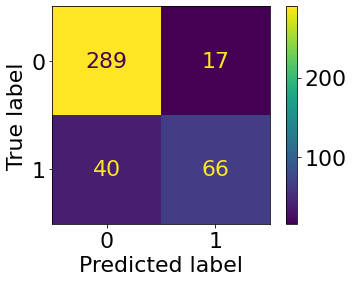

In [49]:
# Plot confusion matrix
plot_confusion_matrix(best_log_reg, X_test_log_reg, y_test);

In [50]:
# Display misclassified posts, sorted by y_proba
log_reg_misclassified = best_log_reg_results.loc[best_log_reg_results['y_true'] !=
                                                 best_log_reg_results['y_predict']].sort_values('y_proba', ascending=False)
log_reg_misclassified

,text,y_true,y_predict,y_proba
727,want pay grocery several month ago went weekly...,0,1,0.998320
308,disappearing man wheres larry found subreddit ...,0,1,0.991782
186,return broken toy see parent bought one toy to...,0,1,0.991646
524,customer service rep complaining customer badm...,0,1,0.960775
884,even bother advertising australia big automoti...,0,1,0.959271
187,preorder bonus pain happened rather recently p...,0,1,0.943928
414,loud customer evil robot self checkout lane st...,0,1,0.919802
58,return used litter box placed order curbside p...,0,1,0.911743
574,first encounter karen grocery store grandma ch...,0,1,0.757024
441,cashier could hole female work hospitality hou...,0,1,0.709912


In [51]:
# The false positive below had a predicted P(y=1) of 0.998320
log_reg_misclassified.iloc[0]['text']

'want pay grocery several month ago went weekly shopping trip big box store pregnant one year old wrangle mom went together get grocery go self checkout scanning one register scanning another one close finished scanning bagging grocery son began fuss realized poopy diaper mom already paid grocery asked put mine cart went changed diaper one diaper change later walking store notice people checking receipt unbagged item try remember put receipt stuff bagged bother asking evening entering receipt checkbook find receipt store look everywhere find oh well look online pull internet find trace lt store name gt transaction card weird transaction always show within minute wracking brain trying figure suddenly realize remember actually paying grocery seems impossible people watching self checkout surely miss someone walking entire cart full unpaid merchandise later night transaction still showing online husband advises go back next day see fast forward next day walk wally world see one yellow ves

In [52]:
# The false negative below had a predicted P(y=1) of 0.000009
log_reg_misclassified.iloc[-1]['text']

'finding someone flash drive returning owner okay first started job little year ago overall still learning thing worked retail let alone job general one afternoon asked go fetch cart getting low upfront go cart corral collect cart look see flash drive ground absolute context still young really know better found flash drive likely someone looking thought free flash drive pocketed story okay really part wrong thought honestly way nice person still pocketed flash drive idea maybe could find flash drive may belong co worker well old understand tech enough feeling turned would sat box year straight tossed away thought take chance pocketing see info flash drive could gather got home day end get home first thing throw flash drive find literally someone life career folder blueprint house construction plan complexity still understand know enough could hell thorn forever lost scrolled way one file found name number gave person call luckily pick say hello person name gentleman responds yes speaki

For Logistic Regression, there were more false negatives than false positives.

In the false positive example above, the text appears to describe another customer at the store rather than the retail staff. This could have thrown off the Logistic Regression model to predict that it came from r/TalesFromRetail.

In the false negative example, even though 'job' and 'co worker' appeared in the text, the model falsely classified this as r/TalesFromTheCustomer rather than r/TalesFromRetail. This could have been because the post was about returning someone's flash drive, and does not describe a generic experience from a retail staff in a store.

### Multinomial Naive Bayes

The best MultinomialNB model scored the following: 
- test accuracy : 0.834951
- test f1 score : 0.723577
- test ROC AUC : 0.836478
- test precision : 0.635714
- test recall : 0.839623

MultinomialNB can accomodate large feature sets by calculating individual probabilities for each word feature (probability of the word given that the document belongs to a specific class). The probability that a document belongs to a specific class would then be a function of these individual probabilities.

In [53]:
# Instantiate copy of best MultinomialNB model
best_nb = nb_pipe.named_steps['nb']
vec_nb  = nb_pipe.named_steps['cvec']

X_train_nb = vec_nb.fit_transform(X_train)
X_test_nb  = vec_nb.transform(X_test)

# Check coefficients of best Logistic Regression model
best_nb.fit(X_train_nb, y_train)
best_nb_features = pd.DataFrame({'feature'         : vec_nb.get_feature_names(),
                                 'neg class prob'  : np.exp(best_nb.feature_log_prob_[0]),
                                 'pos class prob'  : np.exp(best_nb.feature_log_prob_[1])})

# Check coefficients highly correlated to target (r/TalesFromRetail)
best_nb_features.sort_values('pos class prob', ascending=False).head(10)

,feature,neg class prob,pos class prob
4178,store,0.006232,0.012572
940,customer,0.004850,0.012266
4458,time,0.007952,0.006299
2351,like,0.006524,0.006197
2551,manager,0.003047,0.006095
3702,said,0.006378,0.005253
4918,work,0.003761,0.005177
748,come,0.003203,0.005151
987,day,0.007074,0.004947
1788,guy,0.003148,0.004641


In [54]:
# Check coefficients highly correlated to majority (r/TalesFromTheCustomer)
best_nb_features.sort_values('neg class prob', ascending=False).head(10)

,feature,neg class prob,pos class prob
4458,time,0.007952,0.006299
987,day,0.007074,0.004947
2351,like,0.006524,0.006197
3702,said,0.006378,0.005253
4178,store,0.006232,0.012572
1709,got,0.006232,0.003876
2218,know,0.005619,0.004437
3755,say,0.005417,0.004590
2954,order,0.005024,0.002321
4515,told,0.004932,0.004157


In Logistic Regression, each word has either a positive or negative coefficient, contributing to either an increase or decrease in the log-odds of y, the target variable. 

In MultinomialNB, each word has a probability associated with both the positive and negative class. As shown above, the top words associated with r/TalesFromTheCustomer and r/TalesFromRetail overlap, such as 'day', 'said' and 'time'.

This could explain why MultinomialNB has a higher recall but lower precision than Logistic Regression. It does not strictly classify each word as belonging to any one of the two classes, unlike in Logistic Regression where the coefficient is either positive or negative. This allows MultinomialNB to identify a larger number of positive classes, increasing its recall but lowering its precision.

In [55]:
# Create dataframe of test text, y_true and y_predict
best_nb_results = pd.DataFrame({'text'      : X_test,
                                'y_true'    : y_test,
                                'y_predict' : best_nb.predict(X_test_nb),
                                'y_proba'   : [prob[1] for prob in best_nb.predict_proba(X_test_nb)]})

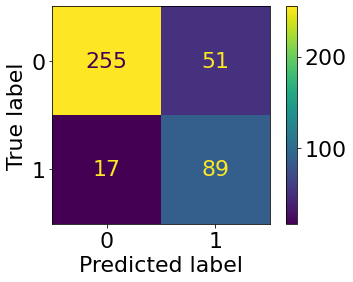

In [56]:
# Plot confusion matrix
plot_confusion_matrix(best_nb, X_test_nb, y_test);

In [57]:
# Display misclassified posts, sorted by y_proba
nb_misclassified = best_nb_results.loc[best_nb_results['y_true'] !=
                                       best_nb_results['y_predict']].sort_values('y_proba', ascending=False)
nb_misclassified

,text,y_true,y_predict,y_proba
414,loud customer evil robot self checkout lane st...,0,1,1.000000e+00
727,want pay grocery several month ago went weekly...,0,1,1.000000e+00
827,reading comprehension eh important popular ret...,0,1,1.000000e+00
744,crazy woman possibly attempt insurance fraud a...,0,1,1.000000e+00
700,buy alcohol cause license real id purpose stam...,0,1,1.000000e+00
...,...,...,...,...
1230,piano incident worked assistant manager thrift...,1,0,1.138867e-06
1021,let come agreement formerly worked trucking co...,1,0,3.671751e-08
1019,momzilla break break law mz momzilla nb nice b...,1,0,1.174567e-08
1231,finding someone flash drive returning owner ok...,1,0,1.845752e-13


In [58]:
# The false positive below had a predicted P(y=1) of 1
nb_misclassified.iloc[0]['text']

'loud customer evil robot self checkout lane story take place store sell novelty cheap electronics general good frequent store sell cheap snack collectable state store us self checkout customer buy item foot traffic store never much always attendent register price check issue going store year never issue interaction employee store picking gift friend snack go checkout gangly middle aged lady ahead got face mask around chin exagerated frown go one self checkout let loud huff someone please help checkout attendant come right asks hate self checkout need someone check employee explains check easy happy assist anything lady keep looping fact hate self checkout evil robot customer thief store employee look dejected run lady item checkout move need pay way woman spit second employee put item bag lady huff puff using debit card storm front door whole debacle checking handful item grumpy customer damn near yelling store employee looked angry deal lady asked employee alright stared lady rude lo

In [59]:
# The false negative below had a predicted P(y=1) of 1.711032e-16
nb_misclassified.iloc[-1]['text']

'customer want item delivered home outraged ask address first post reddit binging post reminds incident took place back working branch large market department store chain south london moved job long time ago please forgive detail bit hazy gist couple bloke eastern europe came wanting buy kettle asking option pick later one speak suspect english good reasonable english explained could pick right away stock wanted could pick later day click collect fee could deliver address provided address uk ireland chose delivery option put detail wanted buy computer came section put delivery detail fun began conversation went something like could ask address please moron want know address said want delivered moron need know address know deliver package otherwise know deliver moron job know thing job ask psychic automatically know address moron feel comfortable giving address know want preserve privacy understand sir give address kettle delivered twenty million address uk pick one random chance either

MultinomialNB models are known to have poor predicted probabilities, as such the probabilities have extremely high and low values.

Similar to Logistic Regression, the false positive example above was about a fellow customer. The language and words describe another customer rather than the retail staff, possibly causing MultinomialNB to incorrectly classify it as r/TalesFromRetail.

In the false negative example, the presence of rare words such as 'psychic' or 'tomfoolery' could have thrown off the model's prediction.

### Support Vector Machine

The best Support Vector Machine model scored the following: 
- test accuracy : 0.849515
- test f1 score : 0.690000
- test ROC AUC : 0.784622
- test precision : 0.734043
- test recall : 0.650943

Support Vector Machines are effective with large dimensions, as dimensionality does not adversely affect the fitting of the hyperplane to classify the data. However, it is not an interpretable model and in the context of natural language processing, the effects of individual words cannot be determined from the fitted model. It would thus not be as useful as Logistic Regression or Multinomial Naive Bayes in the context of this project, even though its scores are generally good.

### K-Nearest Neighbours

The best K-Nearest Neighbours model scored the following: 
- test accuracy : 0.817961
- test f1 score : 0.539877
- test ROC AUC : 0.686305
- test precision : 0.771930
- test recall : 0.415094

KNN models do not perform well with large feature sets in general, as the larger the number of dimensions in the model, the closer each distance between any 2 data points will be to the average distance. KNN loses its predictive power when it cannot distinguish which are the closest neighbours to the data point in query.

### Extra Trees and Random Forest

In the initial screening, Extra Trees and Random Forest had the lowest test f1 scores. They had high precision but very low recall, meaning that out of the positive predictions made, a high percentage were true positives, but very few positive predictions were made overall. This could be due to the underlying decision trees having very few (but effective) leaf nodes with positive predictions. For example, a chain of splits for the subreddit data could be as follows: Does it contain the word 'customer'? > Yes > Does it contain the word 'cw'? > Yes > Result: r/TalesFromRetail. This would be a highly effective chain of splits, but very few documents will end up in the resulting leaf node.

## Conclusion

As determined by the screening and grid searching, the best models for distinguishing r/TalesFromTheCustomer and r/TalesFromRetail are:

- **Logistic Regression** with the following parameters
    - CountVectorizer(max_df=0.8, min_df=3, stop_words='english')
    - LogisticRegression(C=1)


- **Multinomial Naive Bayes** with the following parameters
    - CountVectorizer(max_df=0.8, max_features=5000, min_df=2, ngram_range=(1, 2), stop_words='english')
    - MultinomialNB(alpha=1)
    
If we want to **maximize precision and minimize false positives**, **Logistic Regression** would be the best model. The best Logistic Regression model scored the following:
- test accuracy : 0.861650
- test f1 score : 0.698413
- test ROC AUC : 0.783543
- test precision : 0.795181
- test recall : 0.622642

If we want to **maximize recall and minimize false negatives**, **MultinomialNB** would be the best choice. The best Multinomial Naive Bayes model scored the following:
- test accuracy : 0.834951
- test f1 score : 0.723577
- test ROC AUC : 0.836478
- test precision : 0.635714
- test recall : 0.839623

## Recommendations

These 2 NLP classification models were trained on Reddit text data and successfully classified unseen test data into the subreddit they originated from, r/TalesFromTheCustomer or r/TalesFromRetail. In the process, key words belonging to each subreddit were identified.

The precision and recall scores of these models could be further by creating an ensemble model. Misclassified posts of initial models can be given higher weight to train subsequent models, and an aggregate prediction of all the models is given at the end.

These NLP models could be recontextualized to train on actual customer and service staff feedback to identify the most frequent words in the actual feedback from customers and retail staff. Retail executives may want to perform sentiment analysis to identify if the feedback from their customers and retail staff are generally positive or negative.

More generally, this project has used NLP to distinguish between 2 similar yet contrasting perspectives, namely experiences from customers and retail staff. Such NLP techniques can be further developed to train on any 2 contrasting topics of interest, such as Democrat vs Republican views, and distinguish whether a text is likely to have originated from one group or the other. This would be useful in scraping online social media texts to judge overall sentiment.